In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
from numpy import savez_compressed
import SimpleITK as sitk

from time import time

# Required Imports and loading up a scan for processing as presented by Guide Zuidhof

%matplotlib inline

import pydicom
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import zoom
from sklearn.preprocessing import MinMaxScaler, Normalizer

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns 

from skimage import measure, morphology, segmentation
from skimage.transform import resize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from sklearn.model_selection import KFold,GroupKFold,TimeSeriesSplit,train_test_split, StratifiedKFold

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L
import tensorflow.keras.backend as B
import tensorflow.keras.callbacks as C
from tensorflow_addons.optimizers import RectifiedAdam

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l1_l2,l2,l1
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
def set_seed(seed):
    '''
    from os import environ
    environ["PYTHONHASHSEED"] = '0'
    environ["CUDA_VISIBLE_DEVICES"]='-1'
    environ["TF_CUDNN_USE_AUTOTUNE"] ='0'
    '''

    from numpy.random import seed as np_seed
    np_seed(seed)
    import random
    random.seed(seed)
    from tensorflow import random
    random.set_seed(seed)

In [ ]:
SEED = 11
set_seed(SEED)

In [ ]:
testFeP = '../input/lish-moa/test_features.csv'
trainFeP = '../input/lish-moa/train_features.csv'
trainTaSP = '../input/lish-moa/train_targets_scored.csv'
trainTaNP = '../input/lish-moa/train_targets_nonscored.csv'
sample_submission_path = '../input/lish-moa/sample_submission.csv'

In [ ]:
trainFe = pd.read_csv(trainFeP)
trainFe_col = trainFe.columns
trainFe.describe(),trainFe.info()

# 1. Analysis of features distribution and normality tests

In [ ]:
cols_list=trainFe.columns
cols_list

In [ ]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

In [ ]:
trainFe.drop(columns=['sig_id', 'cp_type', 'cp_time', 'cp_dose']).max().max(),trainFe.drop(columns=['sig_id', 'cp_type', 'cp_time', 'cp_dose']).min().min()


In [ ]:
# gaussian percent point function
from scipy.stats import norm
# define probability
p = 0.025
# retrieve value <= probability
value = norm.ppf(p)
print(value)
# confirm with cdf
p = norm.cdf(value)
print(p)

In [ ]:
data = trainFe[cols_list[16]].copy()
std_data = data.std()
mean_data = data.mean()
print(data.mean(),data.std())
pyplot.hist(data, bins=100)
pyplot.show()
qqplot(data, line='s')
pyplot.show()
lam = 1e-3
for k in range(len(data)):
    if norm.cdf(data[k])> (1-lam):
        #print(k, data[k], norm.cdf(data[k]))
        data[k]= norm.ppf(1-lam)
    elif norm.cdf(data[k]) < lam:
        #print(k, data[k], norm.cdf(data[k]))
        data[k]=norm.ppf(lam)
print(data.mean(),data.std())
pyplot.hist(data, bins=100)
pyplot.show()

In [ ]:
qqplot(data, line='s')
pyplot.show()

In [ ]:
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

# 2. Features resampling

In [ ]:
gaussian = np.zeros(len(cols_list))
std_list = np.zeros(len(cols_list))
alpha = 0.05
for k in range(4,len(cols_list)):
    data = trainFe[cols_list[k]]
    # normality test
    stat, p = normaltest(data)
    if p <= alpha: gaussian[k] = 1
    std_list[k]= data.std()
    '''
    print(data.mean(),data.std())
    qqplot(data, line='s')
    pyplot.show()
    '''
print('There are %i not gaussian' %gaussian.sum())

In [ ]:
data = std_list[4:]
print(data.mean(),data.std())
pyplot.hist(data, bins=100)
pyplot.show()

In [ ]:
from scipy import stats

correlation = trainFe.corr(method='pearson')

In [ ]:
correlation.shape

# 3. Counting and listing rows with 'ctl_vehicle'

In [ ]:
trainFe.cp_type.unique()

In [ ]:
lista= trainFe.loc[trainFe.cp_type == 'ctl_vehicle','sig_id']
lista

In [ ]:
kk=0
for i in lista:
    #trainFe = trainFe.drop(trainFe.loc[trainFe.sig_id == i].index)
    kk+=1


In [ ]:
print(kk)

In [ ]:
testFe = pd.read_csv(testFeP)
testFe_col = testFe.columns
testFe.describe(),testFe.info()

In [ ]:
lesta= testFe.loc[testFe.cp_type == 'ctl_vehicle','sig_id']
lesta

In [ ]:
trainTaS = pd.read_csv(trainTaSP)
trainTaS_col = trainTaS.columns
trainTaS.describe(),trainTaS.info()

In [ ]:
trainTaN = pd.read_csv(trainTaNP)
trainTaN_col = trainTaN.columns
trainTaN.describe()

# 4. Verifying that no rows with ctl_vehicle have activations

In [ ]:
k=0
kk=0
for i in lista:
    app=trainTaS.loc[trainTaS.sig_id == i]
    k+=app.drop(columns=['sig_id']).max(axis=1).values[0]
    kk+=1
print(k,kk)

In [ ]:
k=0
kk=0
for i in lista:
    appN=trainTaN.loc[trainTaN.sig_id == i]
    k+=appN.drop(columns=['sig_id']).max(axis=1).values[0]
    kk+=1
print(k,kk)

In [ ]:
app.columns

In [ ]:
appN.columns

In [ ]:
#s.cummax(skipna=False)
k=app.drop(columns=['sig_id']).max(axis=1)
k.values

In [ ]:
k=appN.drop(columns=['sig_id']).max(axis=1)
k.values

In [ ]:
#trainFe.info(), trainTaS.info()

In [ ]:
# it could be used to create new features
sub = pd.read_csv(sample_submission_path)
sub_col = sub.columns
# sub.describe(), sub.info()

# 5. putting zero to test with ctl_vehicle

In [ ]:
cols = sub.drop(columns=['sig_id']).columns
for i in lesta:
    sub.loc[sub.sig_id == i,cols]=0
sub.describe()

# 6. Analysing cp_type, cp_dose, cp_time

In [ ]:
trainFe['cp_type'].unique()

In [ ]:
# column 'cp_type' has only 2 values: 'trt_cp' and 'ctl_vehicle'

lenn = np.array(trainFe['cp_type'])
plt.hist(lenn, bins=3)
plt.show()
#print(lenn.std(),lenn.mean())

In [ ]:
# column 'cp_dose' has only 2 values: 'D1' and 'D2'

lenn = np.array(trainFe['cp_dose'])
plt.hist(lenn, bins=3)
plt.show()
#print(lenn.std(),lenn.mean())

In [ ]:
# column 'cp_time' has only 3 values: 24, 48, 72

lenn = np.array(trainFe['cp_time'])
plt.hist(lenn, bins=5)
plt.show()
print(lenn.std(),lenn.mean())

In [ ]:
''' 
------ sostitusco valori ----------

appoggio['Sex']=appoggio['Sex'].replace(to_replace =['male','female'],value=[0,1]).astype(int)

------ normalizzo le feature ------

from sklearn.preprocessing import MinMaxScaler

features = ['Fare','Fare_B',"Age","family","SibSp","Parch","Pclass",'Embarked','Title','Cabin','Ticket',"Pre_TK","Post_TK"]
mms = MinMaxScaler()

to_norm = appoggio[features]
appoggio[features] = mms.fit_transform(to_norm)

------ creo dummy -----------------

appoggio = pd.get_dummies(appoggio,columns=["Sex"])

'''

# 7a. Outliers remuval

In [ ]:
trainFe.describe()

In [ ]:
outliers_remuval = 'perc'

In [ ]:
if outliers_remuval == 'perc':
    lam = 1e-3
    alto = norm.ppf(1-lam)
    basso = norm.ppf(lam)
else:
    alto = 1
    basso = -1
    
for i in range(4,len(cols_list)):
    data = trainFe[cols_list[i]].copy()
    data[data>alto]=alto
    data[data<basso]=basso
    trainFe[cols_list[i]] = data

    data = testFe[cols_list[i]].copy()
    data[data>alto]=alto
    data[data<basso]=basso
    testFe[cols_list[i]] = data

trainFe.describe()

In [ ]:
testFe.describe()

# 7b. Normalizing features other than sig_id, cp_type, cp_dose, cp_time

In [ ]:
if outliers_remuval == 'perc':
    features = trainFe.drop(columns=['sig_id','cp_type','cp_time','cp_dose']).columns
    to_norm = trainFe[features]
    mms = MinMaxScaler()
    trainFe[features] = mms.fit_transform(to_norm)

In [ ]:
if outliers_remuval == 'perc':
    features = testFe.drop(columns=['sig_id','cp_type','cp_time','cp_dose']).columns
    to_norm = testFe[features]
    mms = MinMaxScaler()
    testFe[features] = mms.fit_transform(to_norm)

In [ ]:
trainFe.describe()

In [ ]:
testFe.describe()

# 8. Creating dummies for cp_type, cp_dose, cp_time

In [ ]:
'''
trainFe['cp_dose'] = trainFe['cp_dose'].replace(to_replace = ['D1','D2'],value=[0,1]).astype(int)
trainFe['cp_type'] = trainFe['cp_type'].replace(to_replace = ['trt_cp','ctl_vehicle'],value=[0,1]).astype(int)
'''
trainFe = pd.get_dummies(trainFe, columns = ['cp_dose'])
trainFe = pd.get_dummies(trainFe, columns = ['cp_type'])
trainFe = pd.get_dummies(trainFe, columns = ['cp_time'])

trainFe.describe()

In [ ]:
'''
testFe['cp_dose'] = testFe['cp_dose'].replace(to_replace = ['D1','D2'],value=[0,1]).astype(int)
testFe['cp_type'] = testFe['cp_type'].replace(to_replace = ['trt_cp','ctl_vehicle'],value=[0,1]).astype(int)
'''
testFe = pd.get_dummies(testFe, columns = ['cp_dose'])
testFe = pd.get_dummies(testFe, columns = ['cp_type'])
testFe = pd.get_dummies(testFe, columns = ['cp_time'])
testFe.describe()

In [ ]:
#print('trainFe:\n',trainFe.columns,'\ntestFe:\n',testFe.columns,'\ntrainTaS:\n',trainTaS.columns,'\ntrainTaN:\n',trainTaN.columns,'\nsub:\n',sub.columns)

In [ ]:
'''
tra = pd.read_csv(f"{ROOT}/train.csv")
tra.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")


tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient") # appiccica a sub le colonne di Chunk a parte week

'''

In [ ]:
'''
trainFe['WHERE'] = 'train' 
trainFe = trainFe.merge(trainTaS, on='sig_id')
trainFe = trainFe.merge(trainTaN, on='sig_id') 
trainFe.info()
testFe['WHERE'] = 'test' sub['WHERE'] = 'sub'
data = trainFe.append([testFe,sub])
'''

# 9. Creating arrays for training the model

In [ ]:
train_esteso = trainTaS.merge(trainTaN, how='inner')

In [ ]:
trainTaS.describe()

In [ ]:
trainTaN.describe()

In [ ]:
train_esteso.describe()

In [ ]:
train = trainFe.drop(columns=['sig_id']).values
#real = trainTaS.drop(columns=['sig_id']).values
real = train_esteso.drop(columns=['sig_id']).values
realC = real.copy()
test = testFe.drop(columns=['sig_id']).values


In [ ]:
real.sum()

In [ ]:
trainFe.info()

In [ ]:
trainFe.describe(include=[object])  ,trainTaS.describe(include=[object])

In [ ]:
trainTaS.describe()

In [ ]:
testFe.info()

In [ ]:
X_train = train#[:512]
y_real = real#[:512]

In [ ]:
X_train.shape, y_real.shape

# 10. PCA features reduction

In [ ]:
XT = np.append(X_train,test,axis=0)

In [ ]:
X_train.shape, test.shape, XT.shape

In [ ]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig

M = mean(X_train.T, axis=1)
#print(M.shape,'M\n',M)
Mt = mean(test.T, axis=1)
MT = mean(XT.T, axis=1)

In [ ]:
# center columns by subtracting column means
C = X_train - M
#print(C.shape,'C\n',C)
Ct = test - Mt
CT = XT- MT

In [ ]:
# calculate covariance matrix of centered matrix, that is, the joint probability for two features shape: (features, features)
V = cov(C.T)
#print(V.shape,'V = cov(C.T)\n',V)
Vt = cov(Ct.T)
VT = cov(CT.T)

In [ ]:
# factorize covariance matrix
values, vectors = eig(V)
#print(vectors.shape,'vectors\n',vectors)
values_t, vectors_t = eig(Vt)
values_T, vectors_T = eig(VT)

In [ ]:
'''
print(values.shape,'values\n',np.sort(values))
print(values_t.shape,'values_t\n',np.sort(values_t))
print(values_T.shape,'values_T\n',np.sort(values_T))
'''

In [ ]:
C.shape, Ct.shape, CT.shape

In [ ]:
PCA_LIMIT = 1e-4

valori = values_T.copy()
k=0
for i in range(len(values_T)):
    if abs(values_T[i]) < PCA_LIMIT:
        
        CT=np.delete(CT,k+i,1)
        Ct=np.delete(Ct,k+i,1)
        C=np.delete(C,k+i,1)
        valori=np.delete(valori,k+i)
        vectors=np.delete(vectors,k+i,0)
        vectors=np.delete(vectors,k+i,1)
        
        vectors_t=np.delete(vectors_t,k+i,1)
        vectors_t=np.delete(vectors_t,k+i,0)

        vectors_T=np.delete(vectors_T,k+i,0)
        vectors_T=np.delete(vectors_T,k+i,1)
        
        k-=1
print(k)   

In [ ]:
C.shape, Ct.shape, CT.shape, valori.shape, vectors.shape, vectors_t.shape, vectors_T.shape

In [ ]:
P = vectors.T.dot(C.T) # P.T is a projection of C - same projection can be applied to a selection of features based on eigenvalues
#print(P.shape,'P\n',P)
PT = P.T
#print(PT.shape,'PT\n',PT) 

In [ ]:
P_t = vectors_t.T.dot(Ct.T) # P.T is a projection of C - same projection can be applied to a selection of features based on eigenvalues
#print(P_t.shape,'P_t\n',P_t)
P_tT = P_t.T
#print(P_tT.shape,'P_tT\n',P_tT) 

# 11. Model setting

In [ ]:
PCA = False
if PCA == True:
    train = PT
    X_train = PT
    test = P_tT
    print(train.shape, X_train.shape, test.shape)
else:
    train = trainFe.drop(columns=['sig_id']).values
    X_train = train
    #real = trainTaS.drop(columns=['sig_id']).values
    test = testFe.drop(columns=['sig_id']).values
    print(train.shape, X_train.shape, test.shape, real.shape)

In [ ]:
L2 = 0
SEED = 23
set_seed(SEED)
INITIALIZER = tf.keras.initializers.GlorotUniform()
MOMENTUM = 0.9

try: 
    del model
    tf.keras.backend.clear_session()
    print('session cleared')
except Exception as OSError:
    pass

checkpoint_filepath = 'checkpointWeight'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
train.shape

In [ ]:
train.shape[1]

In [ ]:
MOMENTUM = 0.9
# 'relu', activity_regularizer=l2(regul),
def madel(init, regul):
    model_input = K.Input(shape = (train.shape[1]), name="input")

    x = BatchNormalization(momentum=MOMENTUM)(model_input)
    x = Dense(2048,activation='swish', kernel_initializer=init)(x)
 
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='swish', kernel_initializer=init)(x)
    
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='swish', kernel_initializer=init)(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = Dense(256,activation='swish', kernel_initializer=init)(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    model_output = Dense(206,activation='sigmoid', kernel_initializer=init)(x)

    model_base = K.Model(model_input, model_output, name="output")
    
    return model_base

def madelWN(init, regul):
    model_input = K.Input(shape = (train.shape[1]), name="input")

    x = BatchNormalization(momentum=MOMENTUM)(model_input)
    
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(1024,activation='swish', kernel_initializer=init))(x)

    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(512,activation='swish', kernel_initializer=init))(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(256,activation='swish', kernel_initializer=init))(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    model_output = tfa.layers.WeightNormalization(Dense(206,activation='sigmoid', kernel_initializer=init))(x)

    model_base = K.Model(model_input, model_output, name="output")
    
    return model_base

def madelWN_esteso(init, regul):
    model_input = K.Input(shape = (train.shape[1]), name="input")

    x = BatchNormalization(momentum=MOMENTUM)(model_input)
    
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(2048,activation='swish', kernel_initializer=init))(x)

    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(1024,activation='swish', kernel_initializer=init))(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    x = tfa.layers.WeightNormalization(Dense(256,activation='swish', kernel_initializer=init))(x)
    '''
    x = BatchNormalization(momentum=MOMENTUM)(x)
    x = Dropout(0.65)(x)
    model_output = tfa.layers.WeightNormalization(Dense(608,activation='sigmoid', kernel_initializer=init))(x)

    model_base = K.Model(model_input, model_output, name="output")
    
    return model_base

model_base = madelWN_esteso(tf.keras.initializers.GlorotUniform(),0)
K.utils.plot_model(model_base, "madel.png", show_shapes=True)

In [ ]:
model_base.summary()

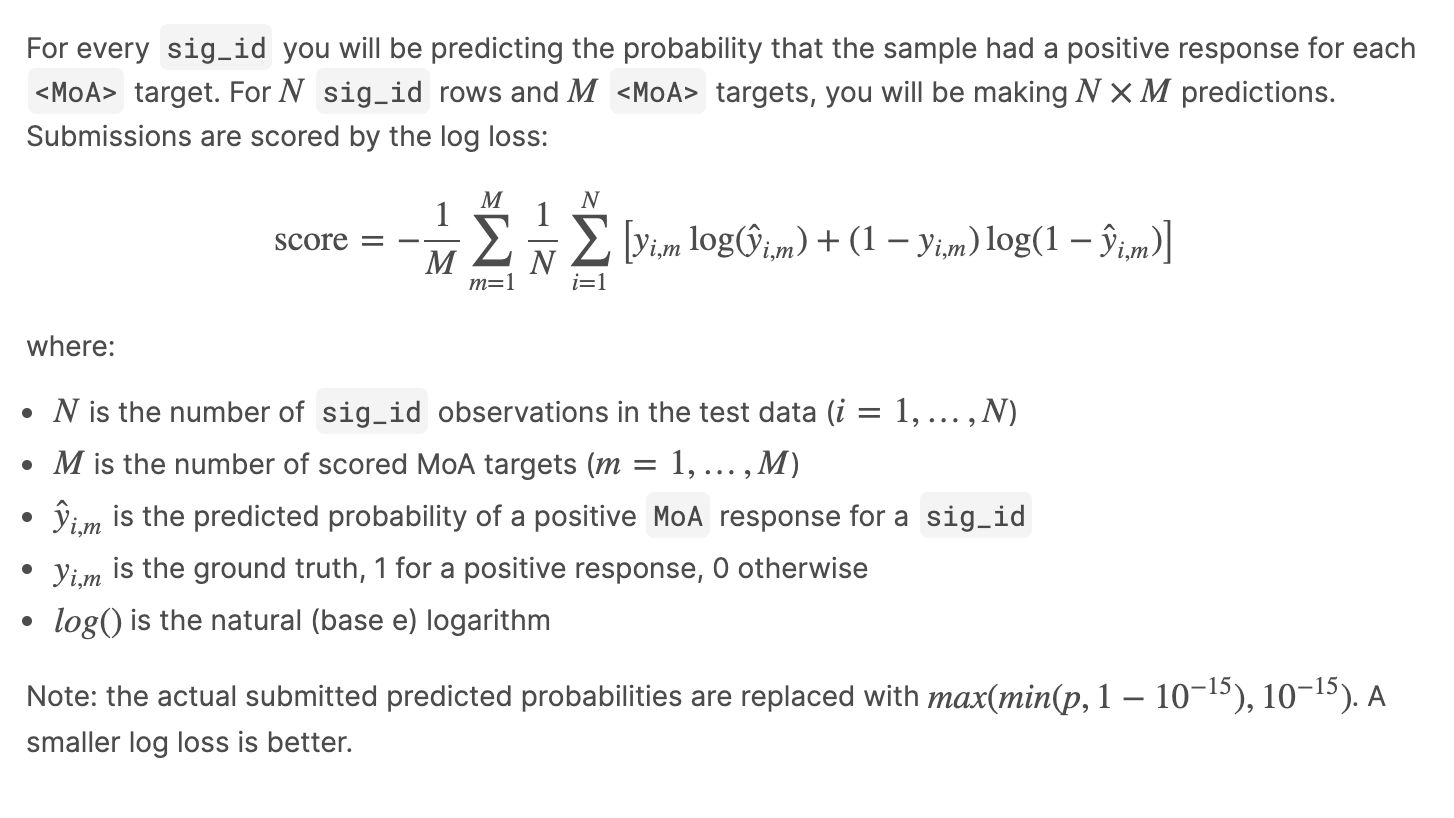

# 12. Metric setting

In [ ]:
def score_MoB(y_true, y_pred, dtype = 'float64'):
    #preda = tf.math.abs(y_pred)
    ytS = tf.slice(y_true, [0, 206], [len(y_true), y_true.shape[1]-206])
    ypS = tf.math.round(tf.slice(y_pred, [0, 206], [len(y_pred), y_pred.shape[1]-206]))
    preda = tf.dtypes.cast(ypS, 'float64')
    predb = tf.math.minimum(preda, tf.constant(1-1e-15,dtype='float64'))
    predb = tf.dtypes.cast(predb, 'float64')
    pred = tf.math.maximum(predb, tf.constant(1e-15,dtype='float64'))
    pred = tf.dtypes.cast(pred, 'float64')
    #print('pred',pred,'tf.math.log((1 - pred)',tf.math.log((1 - pred)))
    yt = tf.dtypes.cast(ytS, 'float64')
    m1 = tf.math.multiply(yt, tf.math.log(pred))
    m2 = tf.math.multiply((1 - yt), tf.math.log(1-pred))
    metric = m1+m2
    return -B.mean(B.mean(metric, axis = -1), axis=0)

def score_MoC(y_true, y_pred, dtype = 'float64'):
    #preda = tf.math.abs(y_pred)
    ytS = tf.slice(y_true, [0, 206], [len(y_true), y_true.shape[1]-206])
    ypS = tf.slice(y_pred, [0, 206], [len(y_pred), y_pred.shape[1]-206])
    preda = tf.dtypes.cast(ypS, 'float64')
    predb = tf.math.minimum(preda, tf.constant(1-1e-15,dtype='float64'))
    predb = tf.dtypes.cast(predb, 'float64')
    pred = tf.math.maximum(predb, tf.constant(1e-15,dtype='float64'))
    pred = tf.dtypes.cast(pred, 'float64')
    #print('pred',pred,'tf.math.log((1 - pred)',tf.math.log((1 - pred)))
    yt = tf.dtypes.cast(ytS, 'float64')
    m1 = tf.math.multiply(yt, tf.math.log(pred))
    m2 = tf.math.multiply((1 - yt), tf.math.log(1-pred))
    metric = m1+m2
    return -B.mean(B.mean(metric, axis = -1), axis=0)

def score_MoA(y_true, y_pred, dtype = 'float64'):
    #preda = tf.math.abs(y_pred)
    preda = tf.dtypes.cast(y_pred, 'float64')
    predb = tf.math.minimum(preda, tf.constant(1-1e-15,dtype='float64'))
    predb = tf.dtypes.cast(predb, 'float64')
    pred = tf.math.maximum(predb, tf.constant(1e-15,dtype='float64'))
    pred = tf.dtypes.cast(pred, 'float64')
    #print('pred',pred,'tf.math.log((1 - pred)',tf.math.log((1 - pred)))
    yt = tf.dtypes.cast(y_true, 'float64')
    m1 = tf.math.multiply(yt, tf.math.log(pred))
    m2 = tf.math.multiply((1 - yt), tf.math.log(1-pred))
    metric = m1+m2
    return -B.mean(B.mean(metric, axis = -1), axis=0)

def loss_MoA(dtype = 'float64'):
    def losss(y_true, y_pred, dtype = 'float64'):
        return score_MoA(y_true, y_pred)
    return losss
    
def rmse(y_true, y_pred):
    return B.sqrt(B.mean(B.square(y_pred - y_true), axis=-1))

def my_acc_score(y_true, y_pred):
    ya = tf.math.round(y_pred)
    yb = tf.math.equal(y_true,ya)
    yc = tf.math.count_nonzero(yb)
    yz = tf.math.maximum(y_true, tf.constant(1,dtype='float32'))
    return yc/tf.math.count_nonzero(yz)

def my_acc_C_score(y_true, y_pred):
    ytS = tf.slice(y_true, [0, 206], [len(y_true), y_true.shape[1]-206])
    ypS = tf.slice(y_pred, [0, 206], [len(y_pred), y_pred.shape[1]-206])
    ya = tf.math.round(ypS)
    yb = tf.math.equal(ytS,ya)
    yc = tf.math.count_nonzero(yb)
    yz = tf.math.maximum(ytS, tf.constant(1,dtype='float32'))
    return yc/tf.math.count_nonzero(yz)

# 13. K-Fold training

In [ ]:
from keras.callbacks import LearningRateScheduler
import math

EPOCHS = 10
train_phase = False
k_folds = 6

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 1e-2
    drop = 0.5
    epochs_drop = int(EPOCHS*.50)

    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


RIF = 1
L2 = 0.0
LR_RA = 1e-2
MIN_LR = 1e-4
BATCH_SIZE = 1024
logLoss = 'binary_crossentropy'

myloss = logLoss # loss_MoA()


SEED = 56
set_seed(SEED)

try: del hz
except:
    pass
hz = pd.DataFrame()


start_all_at = time()
if train_phase:
    kf = KFold(n_splits=k_folds, random_state=2, shuffle=True)
    i = 1
    for train_index, test_index in kf.split(X_train):
        trainData = X_train[train_index]
        valData = X_train[test_index]
        trainLabels = y_real[train_index]
        valLabels = y_real[test_index]
        
        # -----------------------------
        #BATCH_SIZE = len(trainData)    # attenzione al BATCH_SIZE
        # -----------------------------
        
        try: 
            del model
            tf.keras.backend.clear_session()
            print('session cleared')
        except Exception as OSError:
            pass


        set_seed(SEED)
        INITIALIZER = tf.keras.initializers.GlorotUniform()
        tot_steps = max(int(((len(trainData)//BATCH_SIZE))*RIF),1)
        #opt = tfa.optimizers.RectifiedAdam(lr=LR_RA,total_steps=tot_steps, warmup_proportion=0.1, min_lr=MIN_LR) #total_steps=336000
        opt = tf.keras.optimizers.Adam(learning_rate=MIN_LR)
        
        # attenzione scelta modello
        model = madelWN_esteso(INITIALIZER, L2)
        l1_w = model.get_weights()
        model.compile(loss=myloss, optimizer=opt, metrics=[score_MoC, my_acc_score, my_acc_C_score])
        
        # callbacks
        # learning schedule callback
        lrate = LearningRateScheduler(step_decay)
        history = History()
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=50, restore_best_weights=True)
        
        print('Iniizio addestramento fold',i)
        start_at = time()
        
        model.fit(trainData, trainLabels, epochs=EPOCHS, validation_data=(valData,valLabels), batch_size=BATCH_SIZE,
                  verbose=1, callbacks=[history, lrate]) #early_stopping, lrate])
        
        # model.load_weights(checkpoint_path)
        l2_w = model.get_weights()
        
        hz=hz.append([[history.history['loss'],history.history['score_MoC'],history.history['my_acc_score'],history.history['my_acc_C_score'],
                       history.history['val_loss'],history.history['val_score_MoC'],history.history['val_my_acc_score'],history.history['val_my_acc_C_score']]]
                     , ignore_index=True)
        
        print(len(history.history['loss']))
        exec_time = time() - start_at
        print("\nTempo totale di addestramento fold: %i %d minuti e %d secondi" % (i, exec_time/60, exec_time%60),'\n')
        i +=1
else:
    trainData = X_train
    trainLabels = y_real

    try: 
        del model
        tf.keras.backend.clear_session()
        print('session cleared')
    except Exception as OSError:
        pass
    
    # -----------------------------
    #BATCH_SIZE = len(trainData)    # attenzione al BATCH_SIZE
    # -----------------------------
    

    set_seed(SEED)
    INITIALIZER = tf.keras.initializers.GlorotUniform()
    tot_steps = max(int(((len(trainData)//BATCH_SIZE))*RIF),1)
    #opt = tfa.optimizers.RectifiedAdam(lr=LR_RA,total_steps=tot_steps, warmup_proportion=0.1, min_lr=MIN_LR) #total_steps=336000
    opt = tf.keras.optimizers.Adam(learning_rate=MIN_LR)
    
    # attenzione scelta modello
    model = madelWN_esteso(INITIALIZER, L2)
    l1_w = model.get_weights()
    model.compile(loss=myloss, optimizer=opt, metrics=[score_MoC, my_acc_score,my_acc_C_score])

    # callbacks
    # learning schedule callback
    lrate = LearningRateScheduler(step_decay)
    history = History()
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=50, restore_best_weights=True)

    print('Iniizio addestramento fold')
    start_at = time()

    model.fit(trainData, trainLabels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=1, callbacks=[history, lrate])
    
    # model.load_weights(checkpoint_path)
    l2_w = model.get_weights()
    print(len(history.history['loss']))
    exec_time = time() - start_at
    
exec_time = time() - start_all_at
print("\nTempo totale di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60),'\n')

In [ ]:
if train_phase:
    hz=hz.rename(columns={0:'loss',1:'score_MoC',2:'my_acc_score',3:'my_acc_C_score',4:'val_loss',5:'val_score_MoC',6:'val_my_acc_score',7:'val_my_acc_C_score'})

# 14. Training evaluation

In [ ]:
def subplot_model (model_history, epochs, fold, starting_point):
    if epochs <= starting_point: starting_point=0
    xM = model_history['score_MoC'][starting_point:]
    vM = model_history['val_score_MoC'][starting_point:]
    xL = model_history['loss'][starting_point:]
    vL = model_history['val_loss'][starting_point:]
    # Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize=(20,8))
    ax1.set_title("score_MoC Fold %i" % fold)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("score_MoC")
    l1,=ax1.plot(vM,color='blue')
    l2,=ax1.plot(xM,color='green')
    ax1.legend([l1, l2],["val", "train"])
    plt.show
    try:
        ax2.set_title("Loss Fold %i" % fold)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        l1,=ax2.plot(vL,color='blue')
        l2,=ax2.plot(xL,color='green')
        ax2.legend([l1, l2],["val", "train"])
        plt.show
    except: pass

In [ ]:
# def plot_model(model_history, starting_point, metric):
if train_phase:
    for i in range(k_folds):
        a = hz.iloc[i]
        subplot_model(a, EPOCHS, i+1, 2)

In [ ]:
trainData.shape

In [ ]:
testFe.columns

In [ ]:
testFe.describe(include=[object])

In [ ]:
testFe.describe()

In [ ]:
testFe.columns

In [ ]:
x_tr, y_tr = train[512:1024], real[512:1024]

In [ ]:
n_batch = 0

In [ ]:
xxx = model.predict(train)

In [ ]:
lis = np.arange(206,608)
xxx = np.delete(xxx, lis,1)

In [ ]:
xxx.shape

In [ ]:
xxx.sum()

In [ ]:
xxx=np.around(xxx,0)

In [ ]:
xxx.sum()

In [ ]:
y_tr.shape, real.shape

In [ ]:
if n_batch > 0:
    old_weights = model.get_weights()
    new_model = madelWN(INITIALIZER, L2)
    new_weights = new_model.get_weights()
    new_model.set_weights(old_weights)
    new_model.compile(loss=myloss, optimizer=opt, metrics=[my_acc_score,score_MoA])
    pred = new_model.predict(test, batch_size=n_batch)
    prad = new_model.predict(x_tr, batch_size=n_batch)
    new_model.evaluate(x_tr, y_tr,verbose=0, batch_size=n_batch)
    print('new_model')
else:
    #pred = model.predict(testFe.drop(columns=['sig_id']).values)
    pred = model.predict(test)
    prad = model.predict(x_tr)
    model.evaluate(x_tr, y_tr,verbose=0, batch_size=BATCH_SIZE)
    print('model')

In [ ]:
'''
predbb=np.minimum(prad, 1-1e-15)
preddd=np.maximum(predbb, 1e-15)
m1=y_tr*np.log(preddd)+(1-y_tr)*np.log(1-preddd)
m2 = m1.mean(axis = -1)
scoreMoA = -m2.mean(axis = 0)
scoreMoA
'''

In [ ]:
len(pred)

In [ ]:
col = trainTaS.drop(columns=['sig_id']).columns
col

In [ ]:
y_tr.shape, len(y_tr[1])

In [ ]:
'''
t = tf.constant([[0,0,0,1,1,1],
                 [0,0,0,1,1,1],
                 [0,0,0,1,1,1]])
tx = tf.constant([[0.1,0.1,0.1,.8,.8,.8],
                 [1,1,1,1,1,1],
                 [1,1,1,1,1,1]])

tt=tf.slice(t, [0, 3], [len(t), t.shape[1]-3])
ttx=tf.slice(tx, [0, 3], [len(tx), tx.shape[1]-3])

score_MoA(t,tx),score_MoA(tt,ttx)
'''

In [ ]:
lis = np.arange(206,608)
predDF = pd.DataFrame(np.delete(pred, lis,1), columns=col)
pradDF = pd.DataFrame(np.delete(prad, lis,1), columns=col)
pradTaSDF = pd.DataFrame(np.delete(y_tr, lis,1), columns=col)

In [ ]:
predDF.info()

In [ ]:
pradDF.info()

In [ ]:
predDF.describe()

In [ ]:
pradDF.describe()

In [ ]:
pradTaSDF.describe()

In [ ]:
predDF.describe()

# 15. Output preparation

In [ ]:
output = pd.DataFrame({'sig_id': testFe.sig_id})
to_csv = pd.concat([output, predDF], axis = 1)
to_csv.describe()

In [ ]:
cols = to_csv.drop(columns=['sig_id']).columns
# quelli con lesta vanno azzerati
for i in lesta:
    to_csv.loc[to_csv.sig_id == i,cols]=1e-15
    
to_csv.describe()


In [ ]:
trainTaS.describe()

In [ ]:
if not train_phase:
    to_csv.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")